# COCOデータセット

## アノテーションデータの確認とSegmentation画像作成

In [1]:
%matplotlib inline
import copy

import numpy as np
import pickle
import glob
import cv2
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from pycocotools.coco import COCO

In [2]:
# Semgentation画像の色の設定の呼び出し
f = open('../data/t_color.txt',"rb")
t_color = pickle.load(f)
f = open('../data/t_class_name.txt',"rb")
t_color_name = pickle.load(f)

In [3]:
# trainとvalで1回ずつ以下のnotebookを実行してデータを作成する.
data = "train"
#data = "val"

In [4]:
year = "2014"
# resize後のデータの一辺の大きさ.
size_ = 224

In [5]:
# 元データのディレクトリ.
ori_dir = '../data/%s%s/'%(data,year)

# crop,resizeした画像とSegmentation maskを格納するディレクトリを作成.
dir_ = '../data/resize/'

# 学習データ
data_dir = dir_ + '%s%s/'%(data, year)
!mkdir -p $data_dir

# 正解Semantic Segmenation
seg_dir = dir_ + 'semantic_%s/'%(data)
!mkdir -p $seg_dir

# 正解Instance Segmenation
ins_dir = dir_ + 'instance_%s/'%(data)
!mkdir -p $ins_dir

In [6]:
# COCOアノテーションデータ
annFile='../data/annotations/instances_%s%s.json'%(data, year)

In [7]:
# COCO apiの呼び出し.
coco=COCO(annFile)
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())
name=[cat['name'] for cat in cats]
print(len(name))
print('COCO categories: \n\n', ' '.join(name))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n', ' '.join(nms))

loading annotations into memory...
Done (t=7.65s)
creating index...
index created!
80
COCO categories: 

 person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush
COCO supercategories: 
 outdoor appliance person animal sports food vehicle electronic indoor accessory kitchen furniture


### アノテーション画像の確認

In [15]:
# カテゴリからランダムで1枚選ぶ.
catIds = coco.getCatIds(catNms=['person'])
imgIds = coco.getImgIds(catIds=catIds);
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]

In [16]:
img

{'license': 5,
 'file_name': 'COCO_train2014_000000444503.jpg',
 'coco_url': 'http://mscoco.org/images/444503',
 'height': 424,
 'width': 640,
 'date_captured': '2013-11-18 08:13:40',
 'flickr_url': 'http://farm9.staticflickr.com/8175/8042929905_dbb7a3f616_z.jpg',
 'id': 444503}

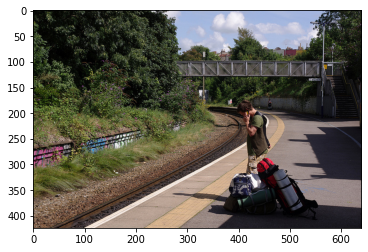

In [17]:
# load and display image
I = Image.open(ori_dir + img['file_name'])
plt.figure()
plt.imshow(I)

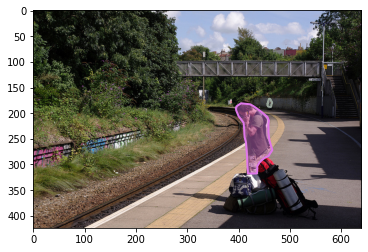

In [18]:
# personクラスが囲われている.
plt.imshow(I)
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

In [19]:
# segmentation画像作成
img_seg = np.zeros((img['height'],img['width'], 3), dtype=int)
img_ins = np.zeros((img['height'],img['width'], 3), dtype=int)
pre_color = []
for i in range(len(t_color_name)-1):
    catIds = coco.getCatIds(catNms=[t_color_name[i]])
    annIds = coco.getAnnIds(imgIds=img["id"], catIds=catIds, iscrowd=False)
    if not annIds:
        continue

    anns = coco.loadAnns(annIds)
    for ann in anns:
        # Instanceの色を作成
        while(True):
            color = np.random.randint(1, 255, 3)
            if not [j for j in range(len(pre_color))
                    if np.sum(pre_color[j] == color) == 3]:
                pre_color.append(color)
                break

        mask = coco.annToMask(ann)
        mask = np.array(mask, dtype=int)
        mask_seg = mask[..., None] * t_color[i]
        mask_ins = mask[..., None] * color

        img_seg = np.where(img_seg == 0, mask_seg, img_seg)
        img_ins = np.where(img_ins == 0, mask_ins, img_ins)

image_seg = copy.deepcopy(img_seg)
image_seg[:, :, 0] = img_seg[:, :, 2]
image_seg[:, :, 2] = img_seg[:, :, 0]
image_ins = copy.deepcopy(img_ins)
image_ins[:, :, 0] = img_ins[:, :, 2]
image_ins[:, :, 2] = img_ins[:, :, 0]

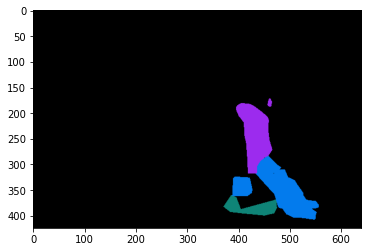

In [20]:
# semantic segmentation
plt.imshow(img_seg)
plt.show()

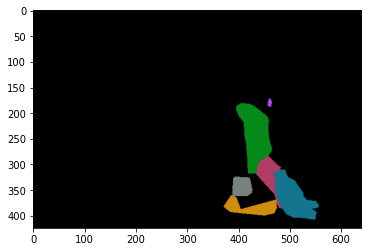

In [21]:
# instance segmentation
plt.imshow(img_ins)
plt.show()

### resizeした画像と正解Segmentation mask作成

In [ ]:
# 以下はtrainデータの場合.
# valデータも同様にSegmentation画像を作成する.
data_name = sorted(glob.glob(ori_dir + "*"))
for img_name in tqdm(data_name):
    # segmentation画像作成
    id_ = int(img_name.split("/")[-1][-10:-4])
    img = coco.loadImgs(id_)[0]
    img_seg = np.zeros((img['height'],img['width'], 3), dtype=int)
    img_ins = np.zeros((img['height'],img['width'], 3), dtype=int)
    pre_color = []
    for i in range(len(t_color_name)-1):
        catIds = coco.getCatIds(catNms=[t_color_name[i]])
        annIds = coco.getAnnIds(imgIds=id_, catIds=catIds, iscrowd=False)
        if not annIds:
            continue

        anns = coco.loadAnns(annIds)
        for ann in anns:
            # Instanceの色を作成
            while(True):
                color = np.random.randint(1, 255, 3)
                if not [j for j in range(len(pre_color))
                        if np.sum(pre_color[j] == color) == 3]:
                    pre_color.append(color)
                    break

            mask = coco.annToMask(ann)
            mask = np.array(mask, dtype=int)
            mask_seg = mask[..., None] * t_color[i]
            mask_ins = mask[..., None] * color

            img_seg = np.where(img_seg == 0, mask_seg, img_seg)
            img_ins = np.where(img_ins == 0, mask_ins, img_ins)
            
    img_seg = Image.fromarray(np.uint8(img_seg))
    img_ins = Image.fromarray(np.uint8(img_ins))
    
    # resizeとcrop
    img = Image.open(img_name)
    if img.size[0] > img.size[1]:
        mal = size_ / img.size[1]
        img = img.resize((int(img.width * mal), int(img.height * mal)))
        img_seg = img_seg.resize(img.size)
        img_ins = img_ins.resize(img.size)
        y_size = img.size[0]
        img = img.crop((int(y_size/2-size_/2), 0, int(y_size/2+size_/2), size_))
        img_seg = img_seg.crop((int(y_size/2-size_/2), 0, int(y_size/2+size_/2), size_))
        img_ins = img_ins.crop((int(y_size/2-size_/2), 0, int(y_size/2+size_/2), size_))
    else:
        mal = size_ / img.size[0]
        img = img.resize((int(img.width * mal), int(img.height * mal)))
        img_seg = img_seg.resize(img.size)
        img_ins = img_ins.resize(img.size)
        x_size = img.size[1]
        img = img.crop((0, int(x_size/2-size_/2), size_, int(x_size/2+size_/2)))
        img_seg = img_seg.crop((0, int(x_size/2-size_/2), size_, int(x_size/2+size_/2)))
        img_ins = img_ins.crop((0, int(x_size/2-size_/2), size_, int(x_size/2+size_/2)))
        
    img = img.resize((size_, size_))
    img_seg = img_seg.resize((size_, size_))
    img_ins = img_ins.resize((size_, size_))

    img.save(data_dir + img_name.split("/")[-1])
    img_seg.save(seg_dir + img_name.split("/")[-1][:-4] + '.png')
    img_ins.save(ins_dir + img_name.split("/")[-1][:-4] + '.png')


### 標準化用計算

##### 学習/評価の標準化に用いる学習データの平均と標準偏差を予め計算しておく.

In [ ]:
dir_img = sorted(glob.glob("../data/resize/train" + year + "/*"))
sum_ = [0, 0, 0]
for i in tqdm(range(len(dir_img))):
    img = np.array(Image.open(dir_img[i]))
    if len(img.shape) != 3:
        
        img = np.tile(img[:, :, None], (1, 1, 3))
    if img.shape[2] == 4:
        img = img[:, :, :3]
    img = np.sum(np.sum(img, axis=0), axis=0)
    sum_ += img
sum_ = sum_ / (len(dir_img)*(224*224)*225)
print("平均")
print(sum_)

In [ ]:
std = [0, 0, 0]
for i in tqdm(range(len(dir_img))):
    img = np.array(Image.open(dir_img[i]))/255
    if len(img.shape) != 3:
        img = np.tile(img[:, :, None], (1, 1, 3))
    if img.shape[2] == 4:
        img = img[:, :, :3]
    img = (img-sum_)**2
    img = np.sum(np.sum(img, axis=0), axis=0)
    std += img
std = std / (len(dir_img)*(224*224))
std = np.sqrt(std)
print("標準偏差")
print(std)